# Cambio Climático através de los años

## Instalar dependencias

In [1]:
%bash
pip install fbprophet
pip install plotly==4.0.0 --upgrade
pip install cufflinks==0.16

  Using cached https://files.pythonhosted.org/packages/58/f3/a49d3281cc7275164ecf89ad3497556b11d9661faa119becdf7f9d3b2125/plotly-4.0.0-py2.py3-none-any.whl
  Found existing installation: plotly 4.1.1
    Uninstalling plotly-4.1.1:
      Successfully uninstalled plotly-4.1.1
  Using cached https://files.pythonhosted.org/packages/ff/75/3982bac5076d0ce6d23103c03840fcaec90c533409f9d82c19f54512a38a/plotly-3.10.0-py2.py3-none-any.whl
  Found existing installation: plotly 4.0.0
    Uninstalling plotly-4.0.0:
      Successfully uninstalled plotly-4.0.0


cufflinks 0.16 has requirement plotly<4.0.0a0,>=3.0.0, but you'll have plotly 4.0.0 which is incompatible.
plotly-express 0.4.1 has requirement plotly>=4.1.0, but you'll have plotly 4.0.0 which is incompatible.
plotly-express 0.4.1 has requirement plotly>=4.1.0, but you'll have plotly 3.10.0 which is incompatible.


## Aquí resetear la sesión

In [4]:
import pandas as pd
import numpy as np
import calendar
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

# Facebook's Prophet forecasting library
from fbprophet import Prophet

# Standard plotly imports
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

# Cargando Datasets

In [5]:
# Read in the raw temperature and emissions datasets (they are in CSV format) 
raw_t = pd.read_csv('../raw_data/GLB.Ts+dSST.csv', skiprows=1)
raw_e = pd.read_csv('../raw_data/API_EN.ATM.CO2E.PC_DS2_en_csv_v2_10515380/API_EN.ATM.CO2E.PC_DS2_en_csv_v2_10515380.csv', skiprows=3)

# Construyendo el dataset de temperaturas 

In [6]:
date_rng = pd.date_range(start='1/1/1880', end='1/03/2019', freq='M')

type(date_rng[0])
t = pd.DataFrame(date_rng, columns=['date'])
t['Avg_Anomaly_deg_C'] = None
t.set_index('date', inplace=True)

In [7]:
# We only want the monthly data, lets only select that and leave out the seasonal columns 
raw_t = raw_t.iloc[:,:13]

 # Se extrae las temperaturas por año

In [8]:
# Import relevant libraries
import calendar
from datetime import datetime

# Function definition
def populate_df_with_anomolies_from_row(row):
    year = row['Year']
    # Anomaly values (they seem to be a mixture of strings and floats)
    monthly_anomolies = row.iloc[1:]
    # Abbreviated month names (index names)
    months = monthly_anomolies.index
    for month in monthly_anomolies.index:
        # Get the last day for each month 
        last_day = calendar.monthrange(year,datetime.strptime(month, '%b').month)[1]
        # construct the index with which we can reference our new DataFrame (to populate) 
       
        date_index = datetime.strptime("{} {} {}".format(year, month, last_day), '%Y %b %d')
        # Populate / set value @ above index, to anomaly value
        t.loc[date_index] = monthly_anomolies[month]

# Apply function to each row of raw data 
_ = raw_t.apply(lambda row: populate_df_with_anomolies_from_row(row), axis=1)

# Show the first few elements of our newly populated DataFrame
#t.head()

 # Se transforman los números a decimal, y se completa con NaN cualquier dato faltante

In [9]:
# Import Numpy, as library meant for large arrays - we will use it that we 
import numpy as np

# Define function to convert values to floats, and return a 'NaN = Not a Number' if this is not possible
def clean_anomaly_value(raw_value):
    try:
        return float(raw_value)
    except:
        return np.NaN
    
# Apply above function to all anomaly values in DataFrame
t['Avg_Anomaly_deg_C'] = t['Avg_Anomaly_deg_C'].apply(lambda raw_value: clean_anomaly_value(raw_value))

# 'Forward fill' to take care of NaN values
t.fillna(method='ffill', inplace=True)

# Show the first few elements of our newly cleaned DataFrame
#t.head()

# Emisiones C02

## Emisiones C02 Global entre los años 1960-2018 

In [10]:
# Define function to pull value from raw data, using DateIndex from new DataFrame row
def populate_df(row):
    index = str(row['date'].year)
    value = raw_e_world.loc[index]
    return value
  
# Select just the co2 emissions for the 'world', and the columns for the years 1960-2018 
raw_e_world = raw_e[raw_e['Country Name']=='World'].loc[:,'1960':'2018']

# 'Traspose' the resulting slice, making the columns become rows and vice versa
raw_e_world = raw_e_world.T
raw_e_world.columns = ['value']

# Create a new DataFrame with a daterange the same the range for.. 
# the Temperature data (after resampling to years)
date_rng = pd.date_range(start='31/12/1960', end='31/12/2018', freq='y')
e = pd.DataFrame(date_rng, columns=['date'])

# Populate the new DataFrame using the values from the raw data slice
v = e.apply(lambda row: populate_df(row), axis=1)
e['Global CO2 Emissions per Capita'] = v
e.set_index('date', inplace=True)
#e.head()

# En Chile

### Emisiones C02 en Chile entre los años 1960-2018


In [11]:
# Define function to pull value from raw data, using DateIndex from new DataFrame row
def populate_df(row):
    index = str(row['date'].year)
    value = raw_e_chile.loc[index]
    return value
  
# Select just the co2 emissions for the 'world', and the columns for the years 1960-2018 
raw_e_chile = raw_e[raw_e['Country Name']=='Chile'].loc[:,'1960':'2018']

# 'Traspose' the resulting slice, making the columns become rows and vice versa
raw_e_chile = raw_e_chile.T
raw_e_chile.columns = ['value']

# Create a new DataFrame with a daterange the same the range for.. 
# the Temperature data (after resampling to years)
date_rng = pd.date_range(start='31/12/1960', end='31/12/2018', freq='y')
e_chile = pd.DataFrame(date_rng, columns=['date'])

# Populate the new DataFrame using the values from the raw data slice
v = e_chile.apply(lambda row: populate_df(row), axis=1)
e_chile['Chile CO2 Emissions per Capita'] = v
e_chile.set_index('date', inplace=True)
#e_chile.head()

# ================= Visualizando Temperaturas ========================

In [17]:
# Standard plotly imports
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
# Using plotly + cufflinks in offline mode
#import cufflinks
#cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

## Promedio de incremento de temperaturas globales desde 1880

In [18]:
t.resample('A').mean().iplot(kind='line', xTitle='Time (years)', color='#1C7C54',
                  yTitle='Temperature Anomaly (deg. Celsius)', title='Global Temperature Anomalies')

## Emisiones promedio globales de CO2 (Toneladas/per capita) por año desde 1960 a 2014

In [14]:
e.iplot(kind='line', xTitle='Time (years)', color='#3393FF',
                  yTitle='Emissions (Metric Tons per Capita)', title='Global CO2 Emission over Time')

## Emisiones promedio en Chile de CO2 (Toneladas/per capita) por año desde 1960 a 2014

In [15]:
e_chile.iplot(kind='line', xTitle='Time (years)', color='#3393FF',
                  yTitle='Emissions (Metric Tons per Capita)', title='Chile CO2 Emission over Time')

# Pronósticos

## Proyección de la variación de la temperatura

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans



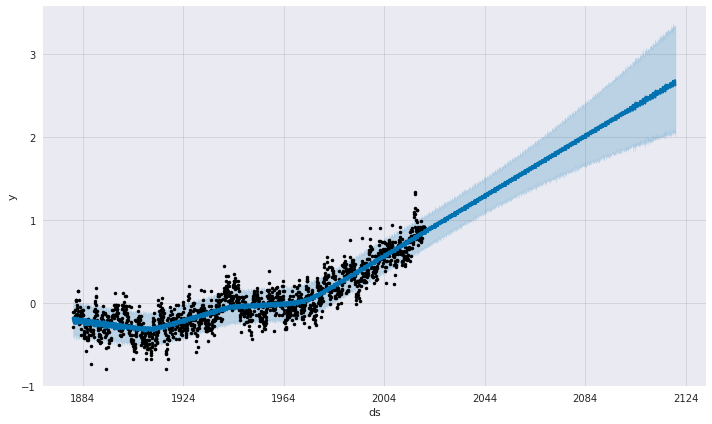

In [16]:
t_prophet = pd.DataFrame()
t_prophet['ds'] = t.index
t_prophet['y'] = t['Avg_Anomaly_deg_C'].values
m = Prophet()
m.fit(t_prophet)
future = m.make_future_dataframe(freq='m', periods=100*12)
forecast = m.predict(future)
m.plot(forecast);

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans



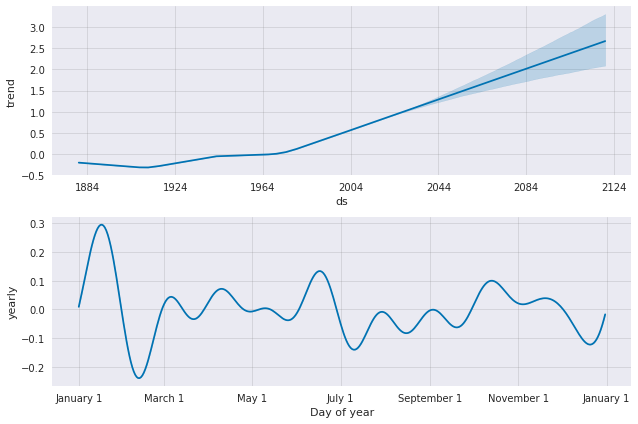

In [19]:
m.plot_components(forecast);